In [1]:
%reload_ext autoreload

In [2]:
%autoreload 2
import math
import numpy as np

from BoseHubbardHamiltonian_class import BoseHubbardHamiltonian

from qiskit.quantum_info import Pauli, Operator
from qiskit.quantum_info import SparsePauliOp

from symmer.operators import PauliwordOp, QuantumState
from symmer.projection import QubitTapering 

import rustworkx as rx
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

from symmer.operators import IndependentOp
from scipy.linalg import eigh
import scipy.sparse

C:\Users\User\OneDrive\Desktop\Martina\Tesi\tapenv\lib\site-packages\cotengra\hyperoptimizers\hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [3]:
#line lattice 
num_nodes = 3 #number of sites in the lattice 
boundary_condition = BoundaryCondition.OPEN #open lattice
line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=boundary_condition)

In [4]:
#triangular lattice 
rows = 4
cols = 3
boundary_condition = BoundaryCondition.PERIODIC

triangular_lattice = TriangularLattice(rows=rows, cols=cols, boundary_condition=boundary_condition)

In [5]:
#cubic lattice
size = (3, 4, 5)
boundary_condition = (
    BoundaryCondition.OPEN,
    BoundaryCondition.OPEN,
    BoundaryCondition.OPEN,
)
cubic_lattice = HyperCubicLattice(size=size, boundary_condition=boundary_condition)

# function for setting the positions
def indextocoord_3d(index: int, size: tuple, angle) -> list:
    z = index // (size[0] * size[1])
    a = index % (size[0] * size[1])
    y = a // size[0]
    x = a % size[0]
    vec_x = np.array([1, 0])
    vec_y = np.array([np.cos(angle), np.sin(angle)])
    vec_z = np.array([0, 1])
    return_coord = x * vec_x + y * vec_y + z * vec_z
    return return_coord.tolist()


pos = dict([(index, indextocoord_3d(index, size, angle=math.pi / 4)) for index in range(np.prod(size))])


In [6]:
#general lattice
graph = rx.PyGraph(multigraph=False)  # multigraph shoud be False
graph.add_nodes_from(range(4))
weighted_edge_list = [
    (1, 0, 1.0), 
    (1, 2, 1.0), 
    (1, 3, 1.0), 
]
graph.add_edges_from(weighted_edge_list)

# make a lattice
general_lattice = Lattice(graph)
set(general_lattice.graph.weighted_edge_list())

{(1, 0, 1.0), (1, 2, 1.0), (1, 3, 1.0)}

In [7]:
#Hamiltonian of the system given the number of sites in the lattice and the number of qubits 
num_qubits = 2
#num_nodes = 3*4*5
H_instance = BoseHubbardHamiltonian(num_nodes, num_qubits, line_lattice)
H_q = H_instance.get_H(1,3)

In [8]:
#Hamiltonian to be tapered
H = PauliwordOp.from_qiskit(H_q)
#print(H)

In [9]:
#IndipendentOp represents algebraically independent sets of Pauli operators for stabilizer manipulation/projections
IndependentOp.symmetry_generators(H, commuting_override=True)

1 IZIZIZ

In [10]:
taper_hamiltonian = QubitTapering(H)
taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis()

-1 IZIIII

In [11]:
print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
print('The symmetry generators are\n')
print(taper_hamiltonian.symmetry_generators)
print('\nand may be rotated onto the single-qubit Pauli operators\n')
print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())
print('\nvia a sequence of rotations e^{i pi/4 R} where\n')
for index, (rot, angle) in enumerate(taper_hamiltonian.stabilizers.stabilizer_rotations):
    print(f'R_{index} = {rot}')

We are able to taper 1 qubits from the Hamiltonian.

The symmetry generators are

1 IZIZIZ

and may be rotated onto the single-qubit Pauli operators

-1 IZIIII

via a sequence of rotations e^{i pi/4 R} where

R_0 =  1.000+0.000j IYIZIZ
R_1 =  1.000+0.000j IYIIII


In [12]:
sec_array = [1]
ham_tap_p = taper_hamiltonian.taper_it(sector=sec_array)
print('Tapered Hamiltonian:\n')
#print(ham_tap_p) #sector = +1

Tapered Hamiltonian:



In [13]:
sec_array = [-1]
ham_tap_n = taper_hamiltonian.taper_it(sector=sec_array)
print('Tapered Hamiltonian:\n')
#print(ham_tap_n) #sector = -1

Tapered Hamiltonian:



In [14]:
H_sparse_matrix = H.to_sparse_matrix
H_array = H_sparse_matrix.toarray()

In [15]:
np.set_printoptions(precision=20)
eigenvalues = eigh(H_array, eigvals_only=True)
#print(eigenvalues)

In [16]:
ham_tap_p_sparse_matrix = ham_tap_p.to_sparse_matrix
ham_tap_p_array = ham_tap_p_sparse_matrix.toarray()
eigenvalues_p = eigh(ham_tap_p_array, eigvals_only=True)
np.set_printoptions(precision=20)
#print(eigenvalues_p)

In [17]:
ham_tap_n_sparse_matrix = ham_tap_n.to_sparse_matrix
ham_tap_n_array = ham_tap_n_sparse_matrix.toarray()
eigenvalues_n = eigh(ham_tap_n_array, eigvals_only=True)
np.set_printoptions(precision=20)
#print(eigenvalues_n)

In [18]:
merged_eigenvalues = np.concatenate((eigenvalues_n, eigenvalues_p))
merged_eigenvalues_sorted = sorted(merged_eigenvalues)
#print(merged_eigenvalues_sorted )

In [19]:
print(len(merged_eigenvalues_sorted ))

64


In [20]:
eigenvalues_sorted = sorted(eigenvalues)

In [21]:
N = 2^(num_nodes*num_qubits)

# Verifica il valore e il tipo di N
print(N, type(N))

# Crea l'array con np.arange
t = np.arange(0.0, N, 1)

4 <class 'int'>


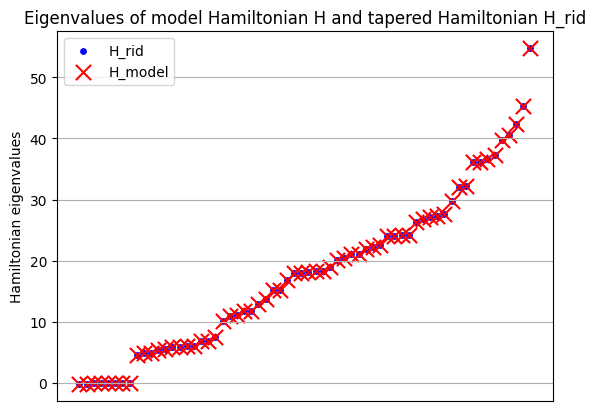

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 64 , 1)
s1 = merged_eigenvalues_sorted
s2 = eigenvalues_sorted 

fig, ax = plt.subplots()

# Primo set di punti
ax.scatter(t, s1, label='H_rid', color = 'b', marker='o', s=15)

# Sovrapponi il secondo set di punti
ax.scatter(t, s2, label='H_model', color = 'r',  marker='x', s = 120)

ax.set(xlabel='', ylabel='Hamiltonian eigenvalues',
       title='Eigenvalues of model Hamiltonian H and tapered Hamiltonian H_rid')
ax.grid()
ax.legend()  # Aggiungi la legenda per distinguere i set di punti

ax.set_xticks([])


fig.savefig("test.png")
plt.show()